<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/COVID_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis estadístico del dataset de COVID-19 proporcionado por la secretaría de salud.

### Objetivos
* Identidicar los factores de los pacientes que aumentan su probabilidad de fallecer o presentar enfermedad grave.
* Identificar si la mortalidad varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si la probabilidad de padecer la enfermedad grave varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si los dias entre el inicio de los sintomas y la atención médica afecta en la mortalidad.
* Conocer si la mortalidad y la positividad cambió en el transcurso de la pandemia.
* Realizar una limpieza y tratamiento de datos para obtener un dataset listo para crear un modelo predictorio de la probabilidad de muerte de un paciente dadas sus características.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import os
import sys
import seaborn as sns

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn import linear_model

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Librería hecha para manejar el dataset de covid
sys.path.insert(1,'/content/drive/MyDrive/Python Scripts/')
import COVID19_MX as covid

## Carga de Dataset principal y auxiliares
Los dataset auxiliares `sexo_df`, `sector_df` y `entidad_df` servirán para usar variables categóricas en el modelo.

In [4]:
aux_dataset_path = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Diccionario%20de%20Datos"
main_dataset_path = "/content/drive/MyDrive/Datos Abiertos"
covid_file = "210727COVID19MEXICO.csv"
sexo_file = "Sexo.csv"
sector_file = "Sector.csv"
entidad_file = "Entidad.csv"

In [5]:
covid_df = pd.read_csv(os.path.join(main_dataset_path,covid_file))
sexo_df = pd.read_csv(os.path.join(aux_dataset_path,sexo_file))
sector_df = pd.read_csv(os.path.join(aux_dataset_path,sector_file))
entidad_df = pd.read_csv(os.path.join(aux_dataset_path,entidad_file))

## Limpieza y Tratamiento de Datos

In [6]:
covid_df.sample(2)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
6628332,2021-07-27,dea77a,2,12,9,1,9,9,5,1,2021-03-17,2021-03-17,9999-99-99,97,2,65,1,2,2,2,2,2,1,2,1,2,2,2,2,2,2,2,97,2,97,6,99,México,97,97
1587706,2021-07-27,154bab,2,12,9,1,9,9,10,1,2020-08-26,2020-08-25,9999-99-99,97,2,41,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,97,7,99,México,97,97


In [7]:
covid_df.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

In [8]:
covid_df.shape

(8265105, 40)

### Se agrega columna Resultado
**Se agrega la columna de `RESULTADO` para facilitar el análisis** 
* Positivo: 1
* Negativo: 2
* Sospechoso: 3

In [9]:
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(covid.getResult)

In [10]:
covid_df[["CLASIFICACION_FINAL","RESULTADO"]].sample(10)

,CLASIFICACION_FINAL,RESULTADO
6073623,7,2
3937370,7,2
8070859,7,2
3549294,7,2
3031233,6,3
2196871,3,1
3602038,3,1
2045705,7,2
162332,3,1
2724346,7,2


In [11]:
date = "2021-07-03"
comulative_cases = covid.getComulativeCases(covid_df)
covid.printCumulativeCases(comulative_cases, date)

Fecha de actualización: 2021-07-03

  Total de casos estudiados: 8265105

  Casos Positivos a SARS-CoV-2: 2771846

  Casos No Positivos a SARS-CoV-2: 5030535

  Casos Con Resultado Pendiente: 462724

  Defunciones Positivas a SARS-CoV-2: 239079

  Tasa de Letalidad: 8.625%

  Tasa de Positividad : 35.526%



### Filtrado de casos con datos incompletos

En el diccionario de datos se identifico que hay valores *no aplica* o *no especificado*, para realizar el análisis hay que eliminar esos valores, ya sea eliminando el caso que los contenga o cambiandolo. El problema es que esos valores están en varias columnas, por lo tanto se tendrá que usar un `for loop`.

In [12]:
# Se filtra el dataset para eliminar casos con información No especificada y se toman solamente los casos positivos.
data_filtered = covid_df[(covid_df["SEXO"] != 99)
& (covid_df["SECTOR"] != 99)
& (covid_df["ENTIDAD_UM"] < 97)
& (covid_df["RESULTADO"] == 1)]

In [13]:
# Se filtran los datos No especificados de las categorias SI-NO (leer el diccionario de datos)
data_filtered["EMBARAZO"] = np.where(data_filtered["SEXO"] == 2, 2, data_filtered["EMBARAZO"])

categorias_si_no = ['INTUBADO','UCI','NEUMONIA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','EMBARAZO']

for cat in categorias_si_no:
  data_filtered = data_filtered[data_filtered[cat] <= 97]
  data_filtered[cat] = data_filtered[cat].apply(lambda x: 1 if x == 1 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Se eliminan los datos no especificados de la columna TIPO_PACIENTE
data_filtered = data_filtered[data_filtered["TIPO_PACIENTE"] != 99]

In [15]:
data_filtered.shape

(2744309, 41)

Oficialmente hay 2,244,268 casos positivos a SARS-COV-2, pero después del filtrado obtuvimos 2,221,525, hay una diferencia de 22,743 casos, esto se debe a que se eliminaron casos con información incompleta. Por la cantidad de datos esta diferencia es estadísticamente insignificante y no supondrá un problema en el análisis o en la creación del modelo.

In [16]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO
3620352,2021-07-27,2d2dee,1,12,22,1,11,22,12,1,2020-12-28,2020-12-24,9999-99-99,0,0,42,1,0,2,2,0,0,0,0,0,0,0,0,0,0,99,1,1,2,97,3,99,México,97,0,1
3278387,2021-07-27,4227dd,1,12,32,2,32,32,56,1,2020-12-13,2020-12-07,9999-99-99,0,0,64,1,0,2,2,0,0,0,0,1,0,1,0,0,0,2,1,1,2,97,3,99,México,97,0,1
7177221,2021-07-27,a9443f,2,4,15,1,15,15,54,1,2021-06-02,2021-05-20,9999-99-99,0,0,88,1,0,2,2,0,0,0,0,1,0,0,0,0,0,1,1,1,1,2,3,99,México,97,0,1
1178191,2021-07-27,0f2399,2,12,9,1,9,9,15,1,2020-07-27,2020-07-22,9999-99-99,0,0,14,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,1,1,2,97,3,99,México,97,0,1
3669422,2021-07-27,320e75,1,12,26,1,26,26,58,1,2020-12-29,2020-12-27,9999-99-99,0,0,23,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,1,1,2,97,3,99,México,97,0,1


### Cambio de tipo de dato de fechas
**Las columnas de `FECHA_SINTOMAS` y `FECHA_INGRESO` correspondientes a la fecha de inicio de sintomas y a la fecha de ingreso a la unidad de atención estan en string, se les cambiará a tipo de dato `datetima` para el manejo de fechas**

In [17]:
data_filtered["FECHA_INGRESO"] = pd.to_datetime(data_filtered["FECHA_INGRESO"], format = "%Y-%m-%d")

In [18]:
data_filtered["FECHA_SINTOMAS"] = pd.to_datetime(data_filtered["FECHA_SINTOMAS"], format = "%Y-%m-%d")

In [19]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].dtypes

FECHA_INGRESO     datetime64[ns]
FECHA_SINTOMAS    datetime64[ns]
dtype: object

In [20]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].sample(5)

,FECHA_INGRESO,FECHA_SINTOMAS
991683,2020-07-14,2020-07-13
2691455,2020-09-12,2020-09-05
374154,2020-05-20,2020-05-16
1649430,2020-08-28,2020-08-24
8252272,2021-07-23,2021-07-23


### Agregado de columna `TIEMPO_ESPERA`
Se agrega la columna `TIEMPO_ESPERA` que indica el tiempo en días que paso desde el inicio de los sintomas `FECHA_SINTOMAS` y el ingreso a la unidad de salud `FECHA_INGRESO`.

In [21]:
data_filtered["TIEMPO_ESPERA"] = data_filtered["FECHA_INGRESO"] - data_filtered["FECHA_SINTOMAS"]
data_filtered["TIEMPO_ESPERA"] = data_filtered["TIEMPO_ESPERA"].apply(lambda x: x.days)

In [22]:
data_filtered["TIEMPO_ESPERA"].dtypes

dtype('int64')

### Agregado de columna `FALLECIDO`
Esta columna será catagórica, indica si el paciente falleció por covid, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [23]:
data_filtered["FALLECIDO"] = data_filtered["FECHA_DEF"].apply(lambda x: 1 if x != "9999-99-99" else 0)

In [24]:
data_filtered[["FECHA_DEF","FALLECIDO"]].sample(10)

,FECHA_DEF,FALLECIDO
4821194,9999-99-99,0
1262426,9999-99-99,0
47045,9999-99-99,0
801422,9999-99-99,0
1413666,9999-99-99,0
2822351,9999-99-99,0
1831268,9999-99-99,0
4999155,9999-99-99,0
1824076,9999-99-99,0
2980700,9999-99-99,0


### Agregado de la columna `ENFERMEDAD_GRAVE`
Esta columna será catagórica, indica si el paciente presentó enfermedad grave.

Se considera que un paciente presentó la enfermedad grave si presenta al menos una de las siguientes situaciones:
* El paciente requirió de intubación.
* El paciente fue diagnosticado con neumonía.
* El paciente requirió ingresar a una Unidad de Cuidados Intensivos.

Los valores posibles en esta columna son los siguientes:
* Si: *1*
* No: *0*

In [25]:
data_filtered["ENFERMEDAD_GRAVE"] = np.where((data_filtered["INTUBADO"] == 1) 
| (data_filtered["NEUMONIA"] == 1)
| (data_filtered["UCI"] == 1) , 1, 0)

In [26]:
data_filtered[["NEUMONIA", "INTUBADO", "UCI", "ENFERMEDAD_GRAVE"]].sample(10)

,NEUMONIA,INTUBADO,UCI,ENFERMEDAD_GRAVE
7616539,0,0,0,0
1431703,0,0,0,0
7637572,0,0,0,0
2857093,0,0,0,0
3816909,0,0,0,0
5060573,0,0,0,0
460353,0,0,0,0
876208,0,0,0,0
7174183,1,0,0,1
1872522,0,0,0,0


### Agregado de columna `HOSPITALIZADO`
Esta columna será catagórica, indica si el paciente fue hospitalizado, si esto no es así se asume que el tratamiento del paciente fue embulatorio, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [27]:
data_filtered["HOSPITALIZADO"] = data_filtered["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [28]:
data_filtered[["TIPO_PACIENTE", "HOSPITALIZADO"]].sample(10)

,TIPO_PACIENTE,HOSPITALIZADO
2096599,1,0
2767896,1,0
640945,1,0
3662726,1,0
591763,1,0
5682134,1,0
4692586,1,0
684371,2,1
2977253,1,0
4096997,1,0



### Combinación del dataframe principal con los dataframes auxiliares.

In [29]:
# Se le cambian los nombres de las columnas a los dataframes auxiliares
sexo_df.columns = ["SEXO", "SEXO_"]
sector_df.columns = ["SECTOR", "SECTOR_ATENDIDO"]
entidad_df.columns = ["ENTIDAD_UM","ESTADO"]

In [30]:
data_filtered = pd.merge(data_filtered, sexo_df, how = "inner", on = "SEXO")
data_filtered = pd.merge(data_filtered, sector_df, how = "inner", on = "SECTOR")
data_filtered = pd.merge(data_filtered, entidad_df, how = "inner", on = "ENTIDAD_UM")

In [31]:
data_filtered[["SEXO_","SECTOR_ATENDIDO","ESTADO"]].sample(5)

,SEXO_,SECTOR_ATENDIDO,ESTADO
1795600,HOMBRE,IMSS,CM
735209,HOMBRE,IMSS,DF
370545,MUJER,SSA,DF
2266781,MUJER,IMSS,QR
1965387,HOMBRE,SSA,PL


## Análisis Exploratorio

En esta sección se obtendrán algunos datos estadísticos que pueden ayudar a comprender el comportamiento de la enfermedad.

In [32]:
# Para esta sección se definio una función para obtener los cartiles
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

### Distribución de edad por sexo de los infectados.

Text(0, 0.5, 'Número de casos confirmados')

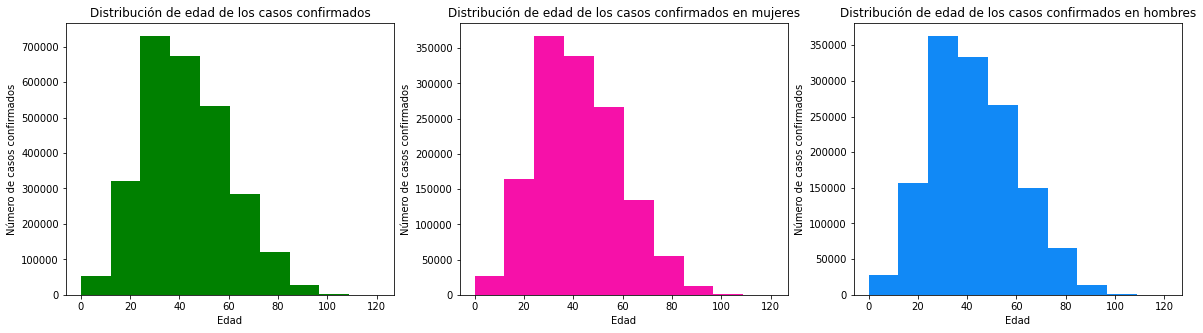

In [33]:
fig, axs = plt.subplots(ncols = 3, nrows = 1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"], color="g")
axs[0].set_title("Distribución de edad de los casos confirmados")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "MUJER"], color="#F611A9")
axs[1].set_title("Distribución de edad de los casos confirmados en mujeres")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

axs[2].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "HOMBRE"], color="#1189F6")
axs[2].set_title("Distribución de edad de los casos confirmados en hombres")
axs[2].set_xlabel("Edad")
axs[2].set_ylabel("Número de casos confirmados")


In [34]:
print("Resumen edad de casos positivos")
age_summary = summary(data_filtered["EDAD"])
age_summary

Resumen edad de casos positivos


{'IQR': 24.0,
 'Q1': 30.0,
 'Q2': 41.0,
 'Q3': 54.0,
 'max': 121,
 'media': 42.65430593067542,
 'mediana': 41.0,
 'minimo': 0}

**Se puede ver que la distribución varía poco entre hombres y mujeres, el 50% de los contagios están entre los 31 y 55 años de edad**

### Distribución de edad en casos hospitalizados y ambulatorios.

Text(0, 0.5, 'Número de casos confirmados')

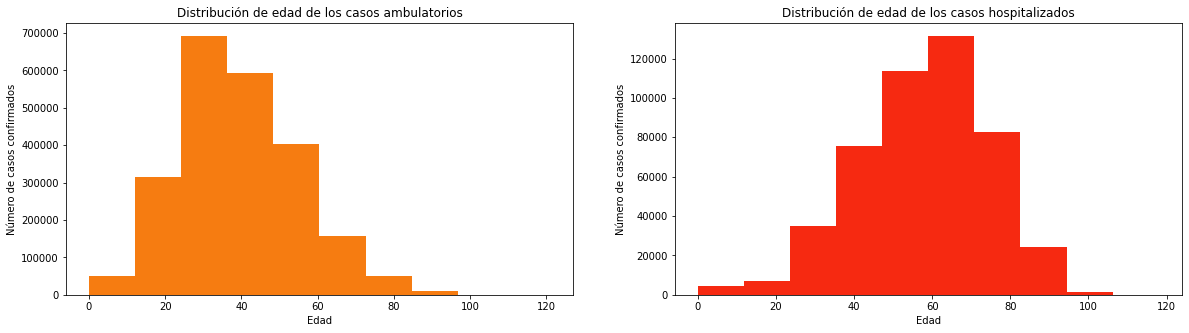

In [35]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0], color="#F67C11")
axs[0].set_title("Distribución de edad de los casos ambulatorios")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1], color="#F62911")
axs[1].set_title("Distribución de edad de los casos hospitalizados")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [36]:
print("Resumen edad de casos ambulatorios")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0])
amb_age

Resumen edad de casos ambulatorios


{'IQR': 22.0,
 'Q1': 28.0,
 'Q2': 38.0,
 'Q3': 50.0,
 'max': 121,
 'media': 39.51604213247378,
 'mediana': 38.0,
 'minimo': 0}

In [37]:
print("Resumen edad de casos hospitalizados")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1])
amb_age

Resumen edad de casos hospitalizados


{'IQR': 22.0,
 'Q1': 47.0,
 'Q2': 59.0,
 'Q3': 69.0,
 'max': 118,
 'media': 57.6151721992922,
 'mediana': 59.0,
 'minimo': 0}

**Se puede apreciar que el grueso de los casos tratados ambulatoriamente están entre los 29 y 51 años de edad mientras que los hospitalizados estan entre los 48 y 70.**

### Distribución por edad de fallecidos

Text(0, 0.5, 'Número de casos confirmados')

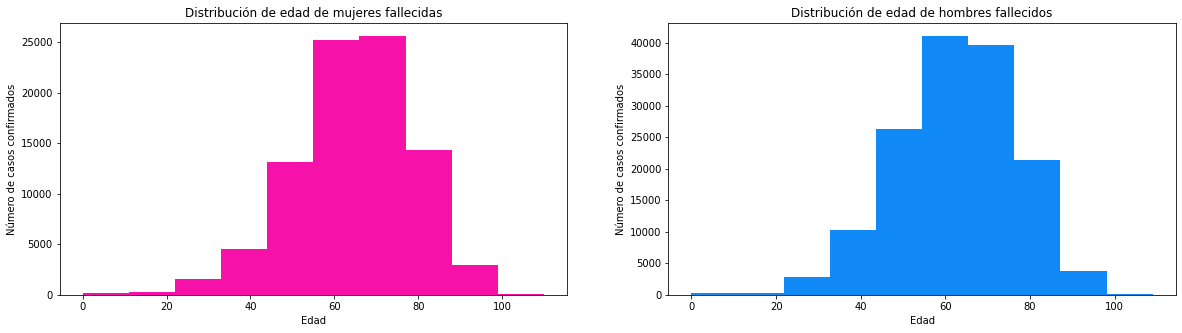

In [38]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)], color="#F611A9")
axs[0].set_title("Distribución de edad de mujeres fallecidas")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)], color="#1189F6")
axs[1].set_title("Distribución de edad de hombres fallecidos")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [39]:
print("Resumen edad en mujeres fallecidas")
female_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)])
female_deceased

Resumen edad en mujeres fallecidas


{'IQR': 18.0,
 'Q1': 56.0,
 'Q2': 65.0,
 'Q3': 74.0,
 'max': 110,
 'media': 64.2832247482801,
 'mediana': 65.0,
 'minimo': 0}

In [40]:
print("Resumen edad en hombres fallecidos")
male_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)])
male_deceased

Resumen edad en hombres fallecidos


{'IQR': 20.0,
 'Q1': 53.0,
 'Q2': 63.0,
 'Q3': 73.0,
 'max': 109,
 'media': 62.69825364623314,
 'mediana': 63.0,
 'minimo': 0}

**El 50% de los fallecidos parece estar entre los 55 y 74 años de edad**

### Comparación de mortalidad en hombres y mujeres

In [41]:
table = pd.crosstab(data_filtered.SEXO_, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


FALLECIDO,0,1,MORTALIDAD
SEXO_,,,
HOMBRE,1231344,145904,0.105939
MUJER,1279264,87796,0.064222


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

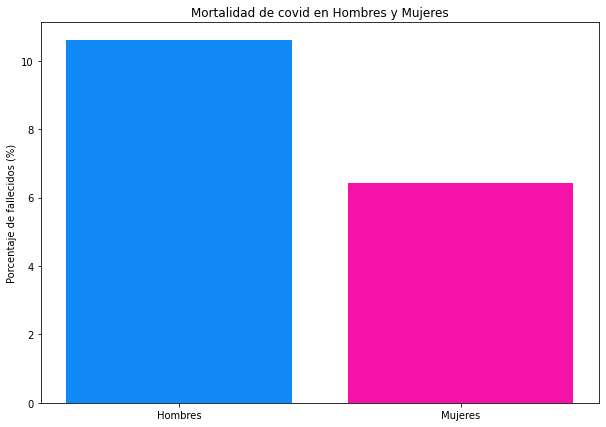

In [42]:
plt.figure(figsize = (10,7))
plt.bar(["Hombres"], table["MORTALIDAD"][0]*100, color = "#1189F6")
plt.bar(["Mujeres"], table["MORTALIDAD"][1]*100, color = "#F611A9")
plt.title("Mortalidad de covid en Hombres y Mujeres")
plt.ylabel("Porcentaje de fallecidos (%)")

## Mortalidad por estado y por sector

### Mortalidad por estado


In [43]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
ESTADO,,,
BS,45489,1864,0.039364
TC,80744,3699,0.043805
DF,829347,44913,0.051373
QT,68796,4669,0.063554
DG,32560,2293,0.065791
NL,128107,10053,0.072763
OC,48674,3927,0.074656
SR,78640,6594,0.077363
QR,37797,3183,0.077672


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

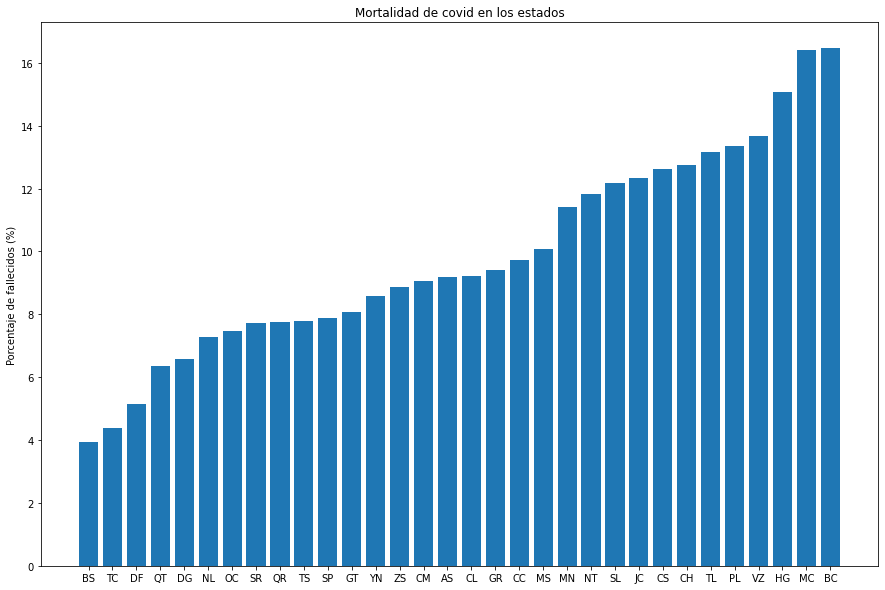

In [44]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid en los estados")
plt.ylabel("Porcentaje de fallecidos (%)")

### Mortalidad por sector de la salud

In [45]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
SECTOR_ATENDIDO,,,
DIF,852,1,0.001172
MUNICIPAL,2303,100,0.041615
SSA,1463342,64192,0.042023
PRIVADA,73203,4328,0.055823
SEMAR,8108,815,0.091337
CRUZ ROJA,245,26,0.095941
ESTATAL,28037,3382,0.107642
IMSS-BIENESTAR,14254,1891,0.117126
IMSS,814811,134966,0.142103


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

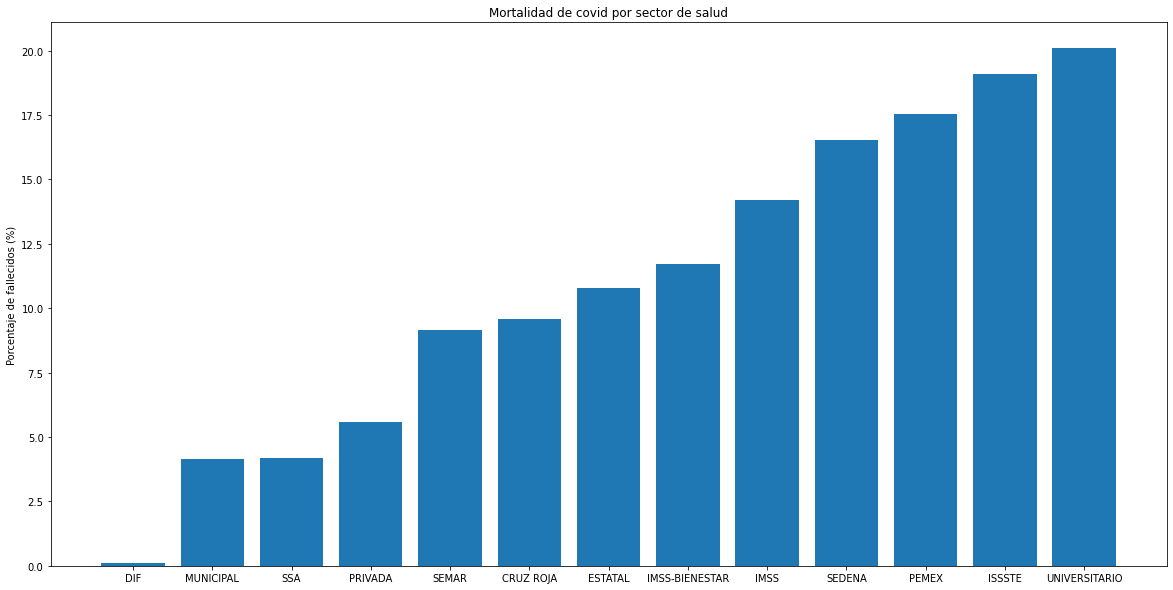

In [46]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid por sector de salud")
plt.ylabel("Porcentaje de fallecidos (%)")

## Proporcion de enfermos grave de covid por estado y por sector

### Proporción de enfermos graves por estado

In [47]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
ESTADO,,,
DG,32624,2229,0.063954
BS,44034,3319,0.070091
TC,77423,7020,0.083133
DF,794760,79500,0.090934
TS,64656,6707,0.093984
ZS,29273,3163,0.097515
CL,63658,6968,0.098661
YN,47638,5667,0.106313
NL,122911,15249,0.110372


Text(0, 0.5, 'Porcentaje de enfermos (%)')

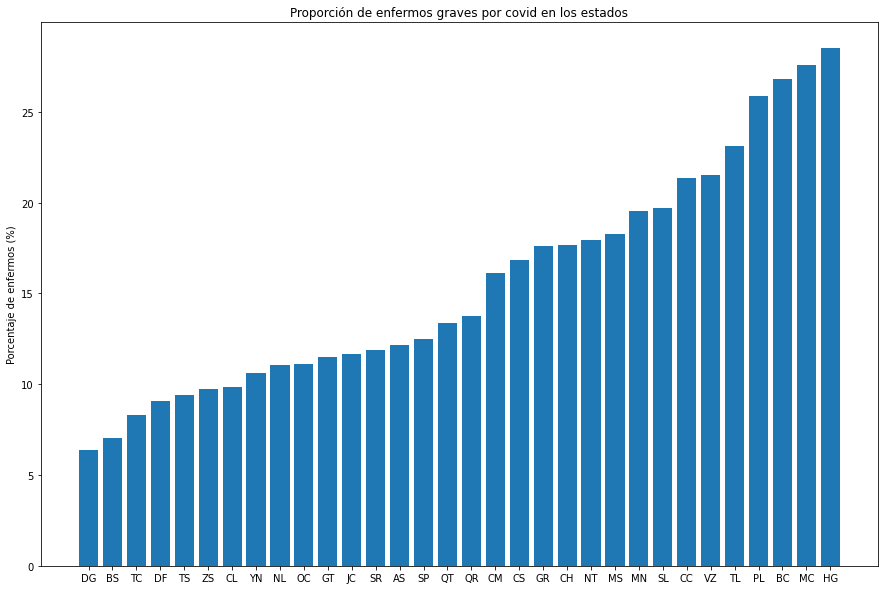

In [48]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por covid en los estados")
plt.ylabel("Porcentaje de enfermos (%)")

### Proporción de enfermos graves por sector de salud

In [49]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
SECTOR_ATENDIDO,,,
DIF,827,26,0.030481
SSA,1392974,134560,0.088090
MUNICIPAL,2168,235,0.097794
CRUZ ROJA,237,34,0.125461
IMSS,787429,162348,0.170933
PRIVADA,61180,16351,0.210896
IMSS-BIENESTAR,12716,3429,0.212388
SEMAR,6831,2092,0.234450
SEDENA,13147,4177,0.241111


Text(0, 0.5, 'Porcentaje de enfermos graves (%)')

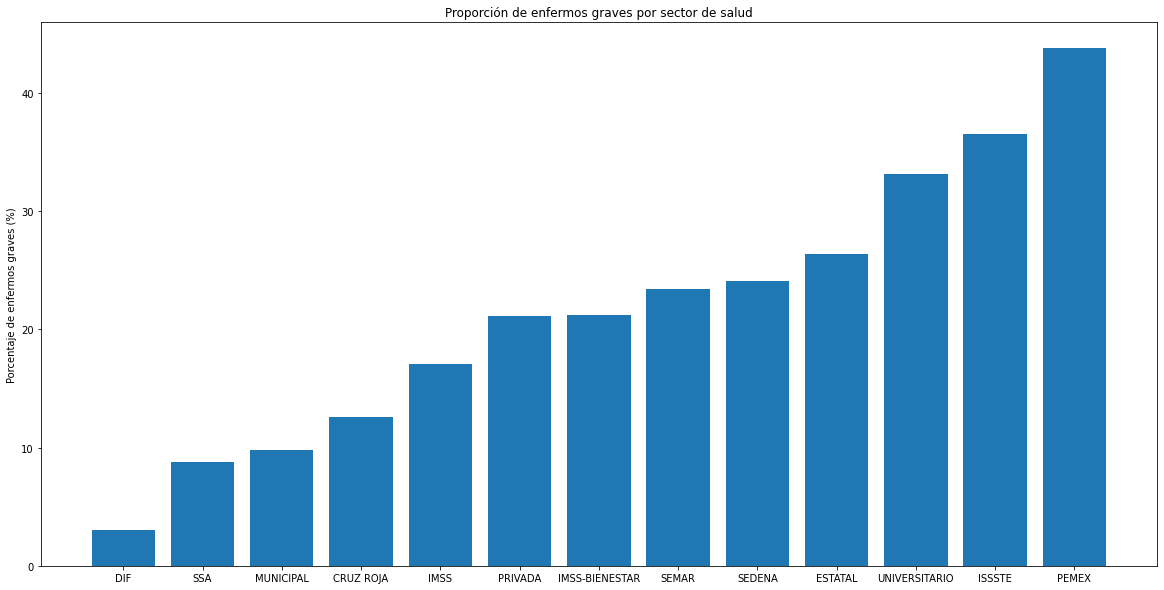

In [50]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por sector de salud")
plt.ylabel("Porcentaje de enfermos graves (%)")

## Mortalidad por días de espera
Se obtendrá la mortalidad según los días entre que el paciente presento síntomas y cuando se atendió en una unidad de salud.

Text(0.5, 0, 'Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud')

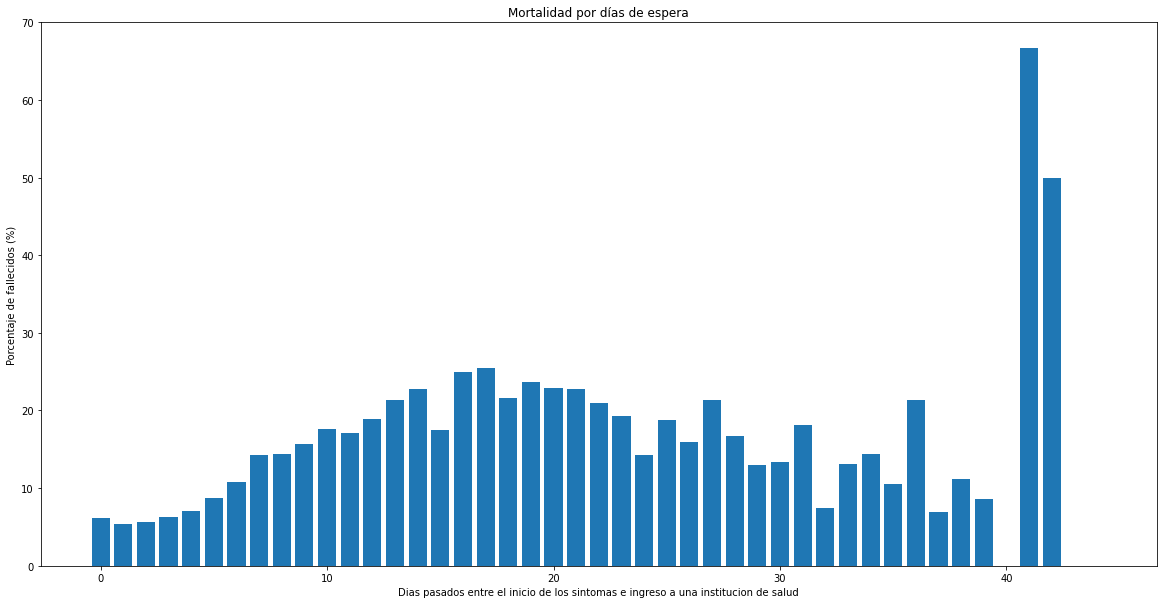

In [51]:
table = pd.crosstab(data_filtered.TIEMPO_ESPERA, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["TIEMPO_ESPERA"])
table = table[0:45]

plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad por días de espera")
plt.ylabel("Porcentaje de fallecidos (%)")
plt.xlabel("Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud")

Se puede ver que aumenta la mortalidad entre más días de espera.

##  Mortalidad y Positividad a lo largo de la pandemia
Se obtendrá la mortalidad y positividad por semana desde la primera semana del 2020 (Se registraban solamente casos sospechosos los primeros meses del 2020)

In [52]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(covid_df, dates)
cases_by_day = pd.DataFrame(cases_by_day)

### Gráfica de casos


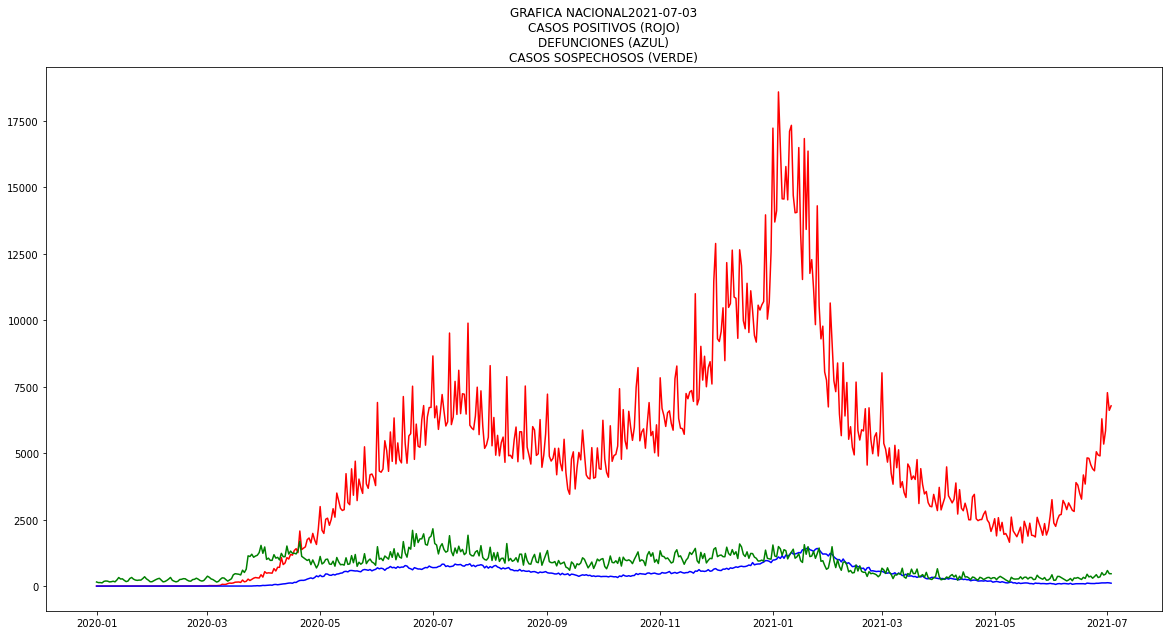

In [53]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL"+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

### Separación de semanas

In [54]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [55]:
cases_by_day.sample(10)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
351,2020-12-17,9671,15298,1111,735,50
164,2020-06-13,4753,4252,1088,693,23
304,2020-10-31,4886,5366,847,449,43
281,2020-10-08,4950,6076,952,353,40
307,2020-11-03,6409,8521,1110,491,43
141,2020-05-21,3213,3222,744,571,20
150,2020-05-30,4060,4073,865,607,21
253,2020-09-10,5519,8431,903,434,36
165,2020-06-14,4631,4499,1052,715,23
428,2021-03-04,4659,14675,687,488,61


In [56]:
cases_by_day.tail(3)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
547,2021-07-01,7271,15404,586,127,78
548,2021-07-02,6605,13481,467,121,78
549,2021-07-03,6775,11627,465,109,78


In [57]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()
cases_by_week.sample(5)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES
SEMANA,,,,
35,33555,48465,6158,3279
8,60,1490,1865,1
12,2250,7700,8591,83
17,15846,19700,6335,2772
67,20598,101023,2434,1633


### Mortalidad

In [58]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]
cases_by_week.head(10)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD
SEMANA,,,,,
0,0,963,1093,0,NaN
1,0,1278,1482,0,NaN
2,0,1508,1717,0,NaN
3,0,1419,1799,0,NaN
4,0,1226,1562,0,NaN
5,0,1393,1575,0,NaN
6,0,1242,1579,0,NaN
7,10,1208,1658,0,0.000000
8,60,1490,1865,1,0.016667


In [59]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])
cases_by_week.head()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
0,0,963,1093,0,NaN,2020-01-01
1,0,1278,1482,0,NaN,2020-01-08
2,0,1508,1717,0,NaN,2020-01-15
3,0,1419,1799,0,NaN,2020-01-22
4,0,1226,1562,0,NaN,2020-01-29


In [60]:
cases_by_week.tail()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
74,18788,67340,1994,600,0.031935,2021-06-02
75,22335,75894,1835,599,0.026819,2021-06-09
76,28949,85450,2313,664,0.022937,2021-06-16
77,35237,89213,2673,753,0.021370,2021-06-23
78,26491,54041,1966,477,0.018006,2021-06-30


Text(0, 0.5, 'Mortalidad en porcentaje (%)')

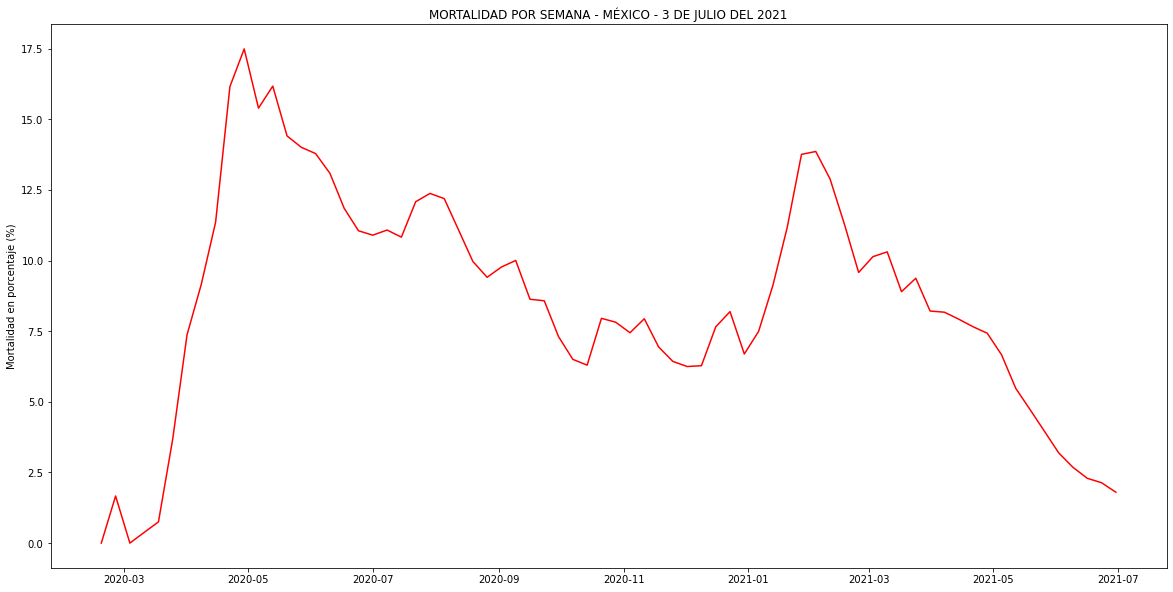

In [61]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

Se puede apreciar que los maximos de la mortalidad coinciden con los picos de las olas que han habido en México.


### Positividad

In [62]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

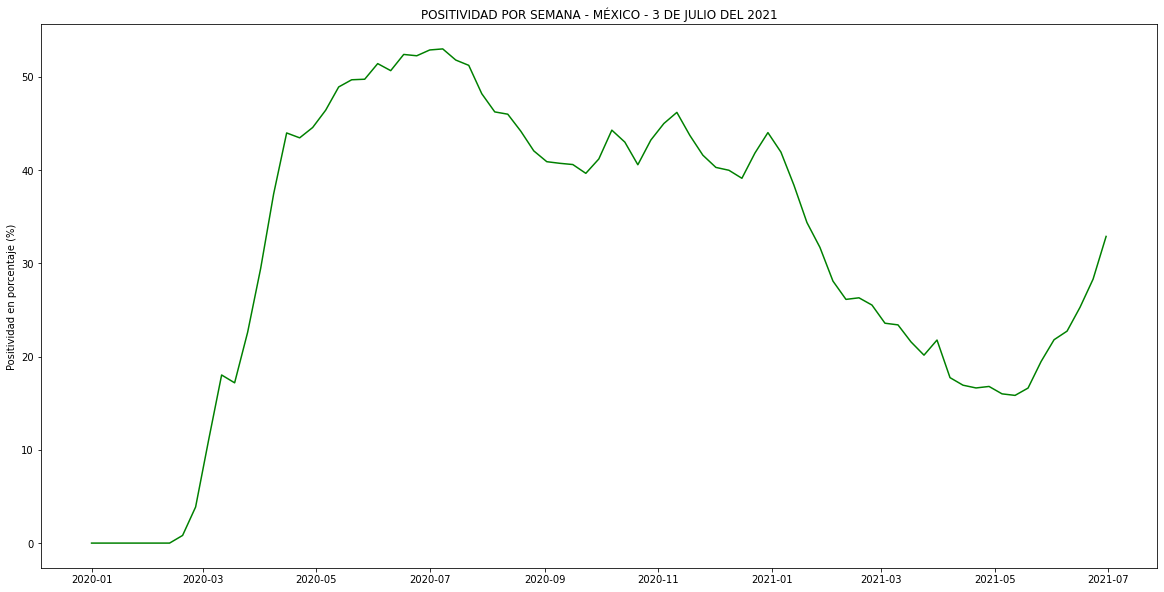

In [63]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

Al igual que con la mortalidad, la positividad cambió durante la pandemia de covid y sus puntos más altos coinciden con los picos de las olas de la epidemia que han habido.

## Guardado Dataset
Se guarda el dataset después de ser limpiado y con datos procesados

In [64]:
dataset_file = "210727COVID19MEXICO_filtered.csv"
data_filtered.to_csv(os.path.join(main_dataset_path, dataset_file))

## Efecto de las vacunas en los grupos de población

In [65]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO,TIEMPO_ESPERA,FALLECIDO,ENFERMEDAD_GRAVE,HOSPITALIZADO,SEXO_,SECTOR_ATENDIDO,ESTADO
686688,2021-07-27,307a58,1,6,9,1,30,9,7,2,2020-08-01,2020-07-25,9999-99-99,0,1,82,1,0,2,2,1,0,0,0,1,0,1,0,0,0,2,2,97,2,97,1,99,México,97,0,1,7,0,1,1,MUJER,ISSSTE,DF
1011661,2021-07-27,c85083,1,12,26,1,26,26,17,1,2021-07-15,2021-07-13,9999-99-99,0,0,26,1,0,2,2,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,3,99,México,97,0,1,2,0,0,0,MUJER,SSA,SR
463491,2021-07-27,37a953,2,12,9,1,9,9,5,1,2020-12-18,2020-12-15,9999-99-99,0,0,45,1,0,2,2,0,0,0,0,0,0,0,1,0,0,1,2,97,1,1,3,99,México,97,0,1,3,0,0,0,MUJER,SSA,DF
1201313,2021-07-27,dfd446,2,4,8,2,8,8,19,1,2021-03-17,2021-03-09,9999-99-99,0,0,31,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,3,99,México,97,0,1,8,0,0,0,HOMBRE,IMSS,CH
1479230,2021-07-27,e202f9,2,4,13,2,13,13,69,1,2021-04-21,2021-04-18,9999-99-99,0,0,53,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1,3,0,0,0,HOMBRE,IMSS,HG


In [66]:
data_filtered.shape

(2744308, 48)

Se separará el dataframe `data_filtered` en 6 grupos:
* Mayores de 60 años
* Entre 50 y 59 años
* Entre 40 y 49 años
* Entre 30 y 39 años
* Entre 20 y 29 años
* Menores de 20 años

In [67]:
data_by_age = {}

In [68]:
data_by_age[">60"] = covid_df[covid_df["EDAD"] >= 60].copy()

In [69]:
data_by_age["50-59"] = covid_df[(covid_df["EDAD"] >= 50) & (covid_df["EDAD"] <= 59)].copy()

In [70]:
data_by_age["40-49"] = covid_df[(covid_df["EDAD"] >= 40) & (covid_df["EDAD"] <= 49)].copy()

In [71]:
data_by_age["30-39"] = covid_df[(covid_df["EDAD"] >= 30) & (covid_df["EDAD"] <= 39)].copy()

In [72]:
data_by_age["20-29"] = covid_df[(covid_df["EDAD"] >= 20) & (covid_df["EDAD"] <= 29)].copy()

In [73]:
data_by_age["<20"] = covid_df[covid_df["EDAD"] <= 19].copy()

In [74]:
keys = data_by_age.keys()
for key in keys:
  print(f"GRUPO EDAD {key}")
  comulative_cases = covid.getComulativeCases(data_by_age[key])
  covid.printCumulativeCases(comulative_cases, date)

GRUPO EDAD >60
Fecha de actualización: 2021-07-03

  Total de casos estudiados: 1103631

  Casos Positivos a SARS-CoV-2: 474912

  Casos No Positivos a SARS-CoV-2: 568539

  Casos Con Resultado Pendiente: 60180

  Defunciones Positivas a SARS-CoV-2: 149635

  Tasa de Letalidad: 31.508%

  Tasa de Positividad : 45.514%

GRUPO EDAD 50-59
Fecha de actualización: 2021-07-03

  Total de casos estudiados: 1211779

  Casos Positivos a SARS-CoV-2: 447343

  Casos No Positivos a SARS-CoV-2: 699882

  Casos Con Resultado Pendiente: 64554

  Defunciones Positivas a SARS-CoV-2: 49873

  Tasa de Letalidad: 11.149%

  Tasa de Positividad : 38.993%

GRUPO EDAD 40-49
Fecha de actualización: 2021-07-03

  Total de casos estudiados: 1607053

  Casos Positivos a SARS-CoV-2: 557524

  Casos No Positivos a SARS-CoV-2: 958688

  Casos Con Resultado Pendiente: 90841

  Defunciones Positivas a SARS-CoV-2: 26295

  Tasa de Letalidad: 4.716%

  Tasa de Positividad : 36.771%

GRUPO EDAD 30-39
Fecha de actualizac

In [75]:
table_age = pd.crosstab(data_filtered.EDAD,data_filtered.FALLECIDO)
table_age["MORTALIDAD"] = table_age[1]/(table_age[0]+table_age[1])*100
table_age = table_age.sort_values(by = ["EDAD"])

In [76]:
table_age["MORTALIDAD"].values

array([ 5.27409717,  2.88461538,  1.06382979,  0.7495069 ,  0.59303188,
        0.36112935,  0.43103448,  0.390625  ,  0.41189931,  0.28735632,
        0.41561258,  0.234375  ,  0.31525023,  0.24883696,  0.20746888,
        0.26996983,  0.30171204,  0.37290622,  0.23330417,  0.26244779,
        0.37297592,  0.37468219,  0.36548126,  0.36685642,  0.45788949,
        0.42700827,  0.59231652,  0.57549793,  0.69612927,  0.75297393,
        0.94422211,  1.00239425,  1.14310115,  1.23535002,  1.44932382,
        1.65641268,  1.78416973,  1.92008917,  2.26567032,  2.49314255,
        2.77442059,  3.18616972,  3.57985838,  3.88891983,  4.40762738,
        4.93213569,  5.27154591,  5.72589583,  5.98673566,  6.55318994,
        7.22202017,  8.06075705,  8.83372539,  9.593503  , 10.45708574,
       11.50794569, 13.00004701, 13.51132289, 14.640625  , 16.19855245,
       17.71576345, 19.84084714, 21.52303095, 22.93584379, 24.20177593,
       26.43130516, 26.88586422, 28.40288399, 30.65200168, 31.59

Text(0.5, 1.0, 'LETALIDAD POR EDAD')

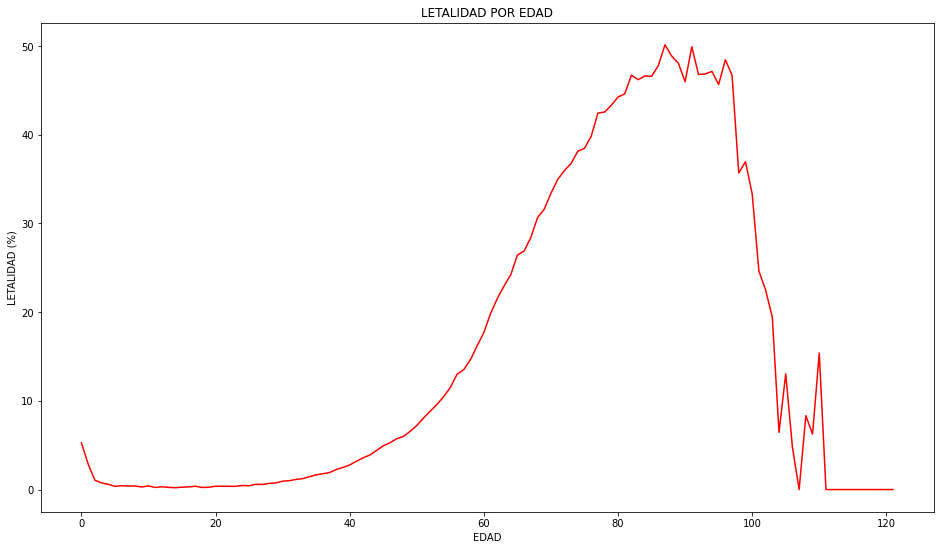

In [77]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

sns.lineplot(x = table_age.index, y = table_age["MORTALIDAD"].values, ax = ax, color = "red")
ax.set_ylabel("LETALIDAD (%)")
ax.set_title("LETALIDAD POR EDAD")

### Graficas de casos, mortalidad y positividad por grúpos de edad
Se espera ver una disminución de la mortalidad y casos en los grupos de edad que ya han sido vacunados

#### Mayores de 60 años

In [78]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age[">60"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

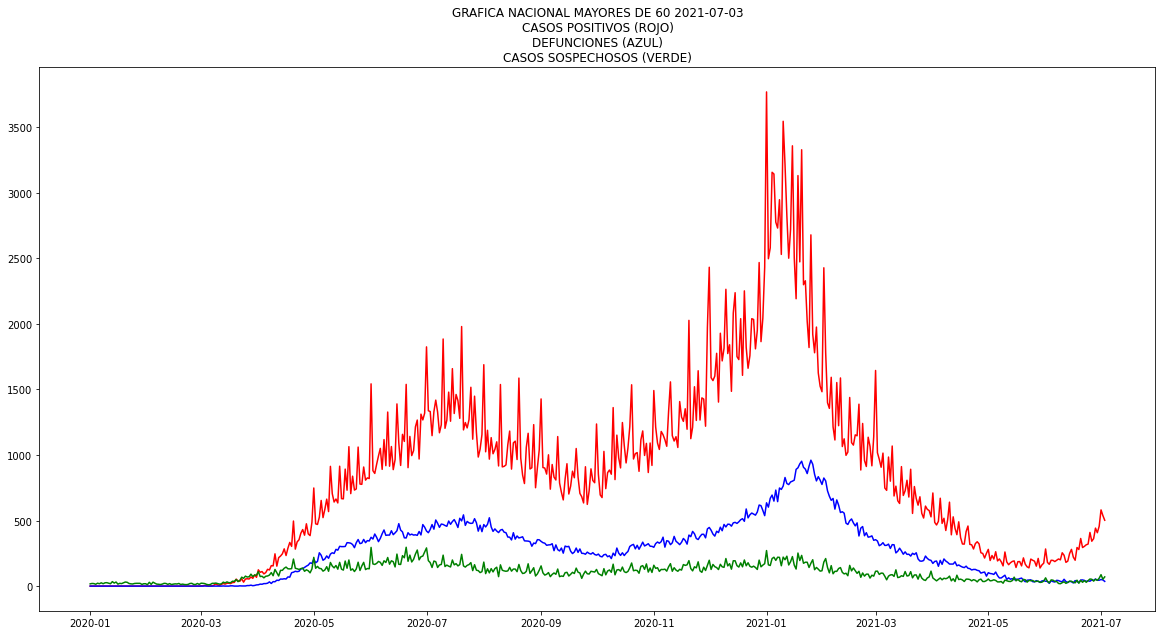

In [79]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MAYORES DE 60 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [80]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [81]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [82]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [83]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

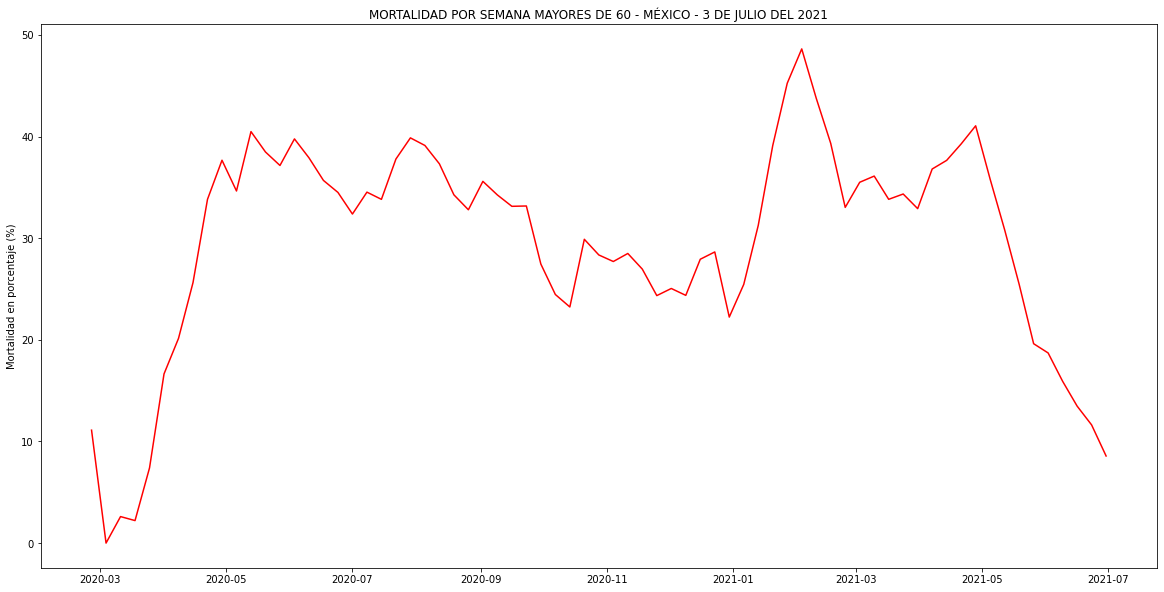

In [84]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [85]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

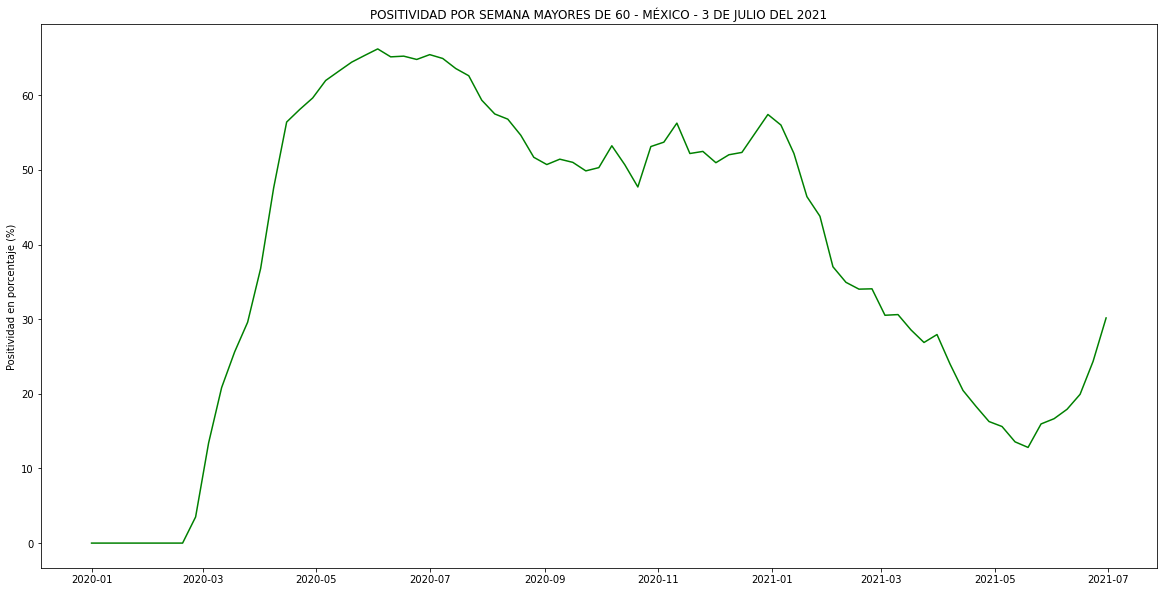

In [86]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 50 y 59 años

In [87]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["50-59"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

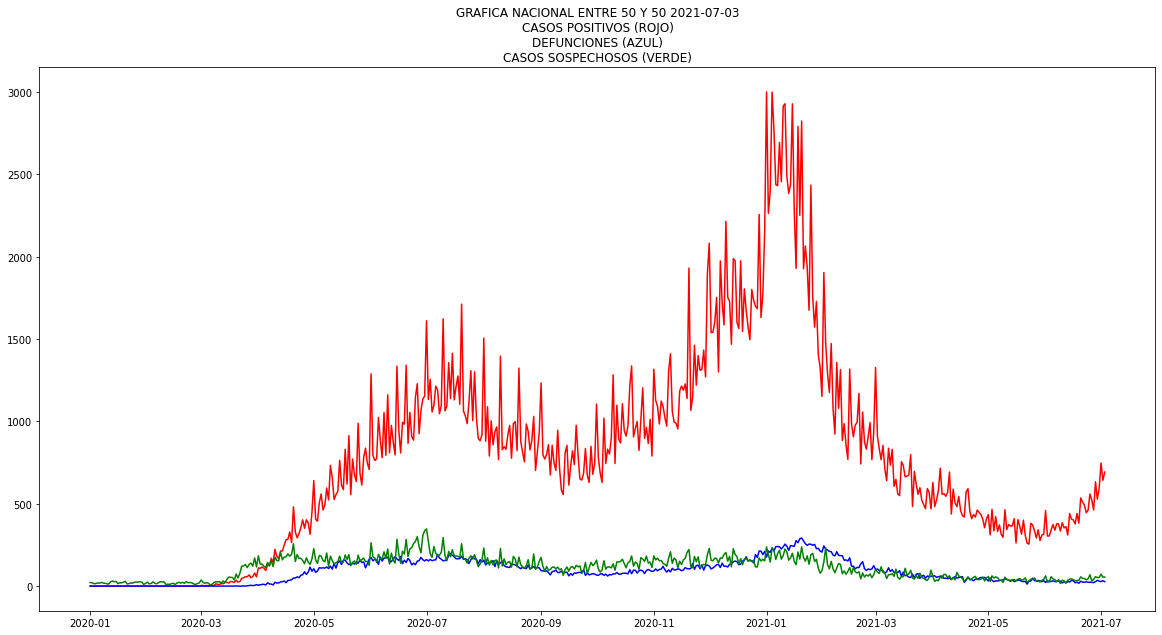

In [88]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 50 Y 50 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [89]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [90]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [91]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [92]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

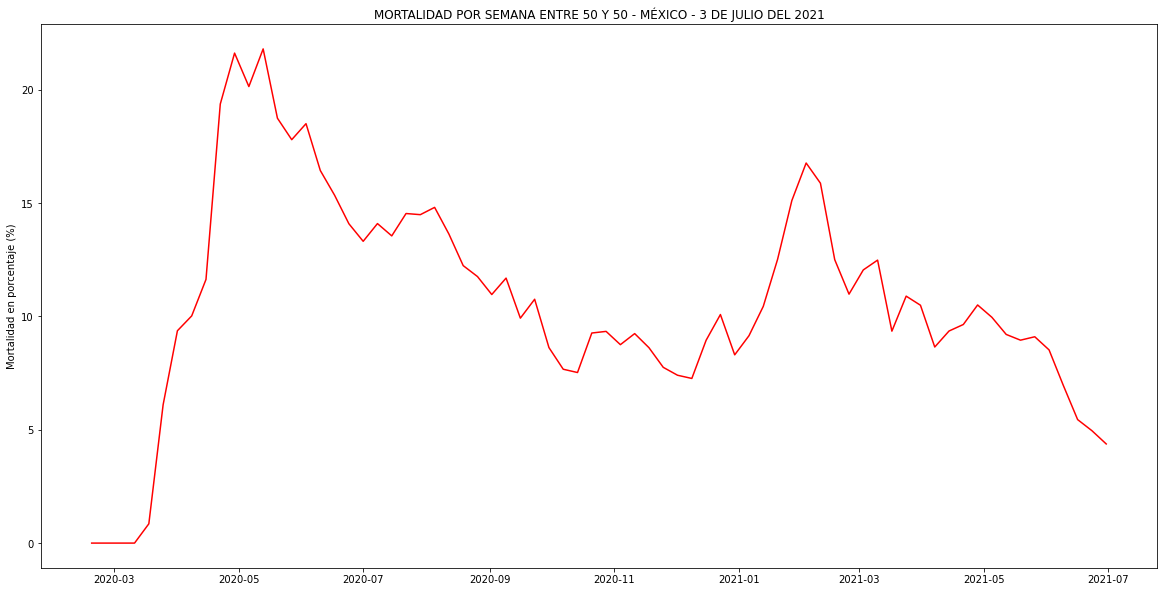

In [93]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 50 Y 50 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [94]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

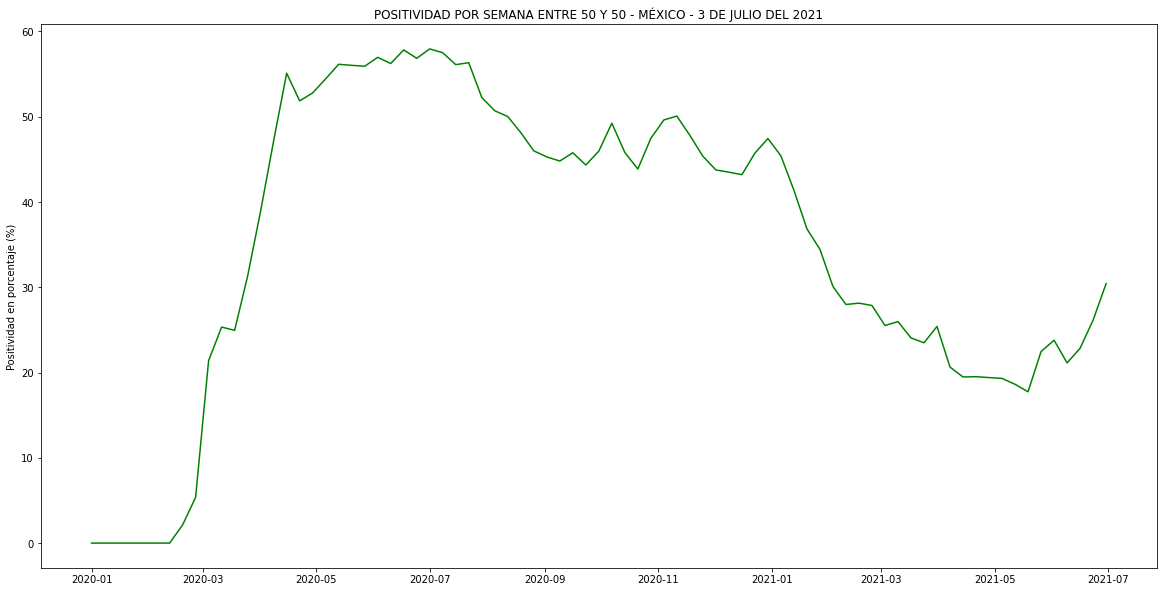

In [95]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 50 Y 50 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 40 y 49 años

In [96]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["40-49"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

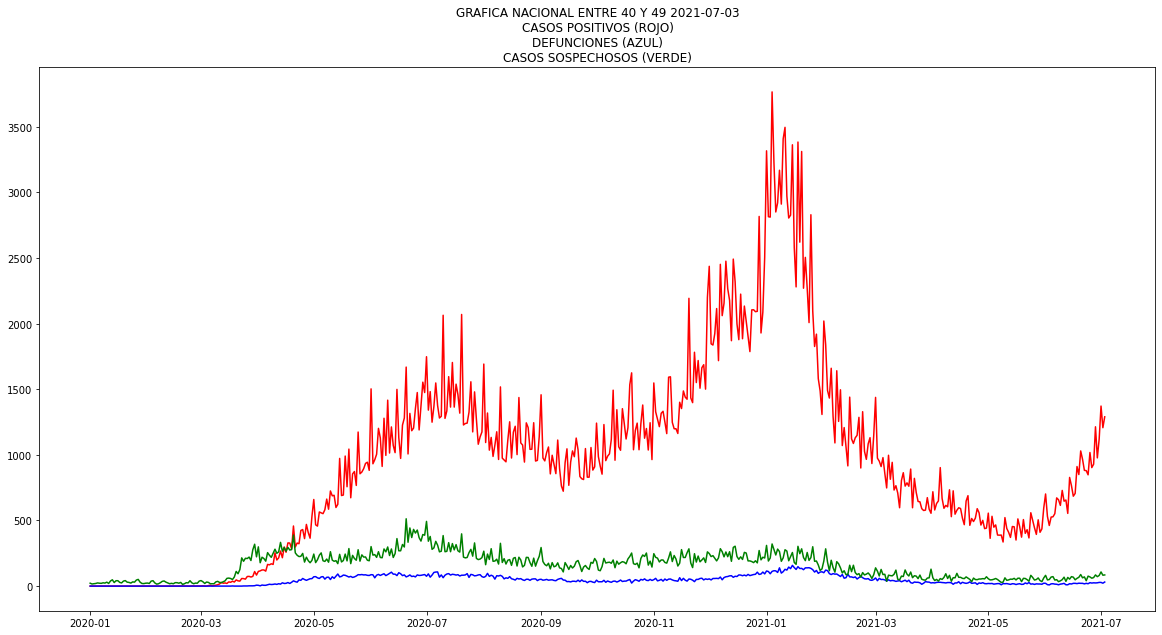

In [97]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 40 Y 49 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [98]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [99]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [100]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [101]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

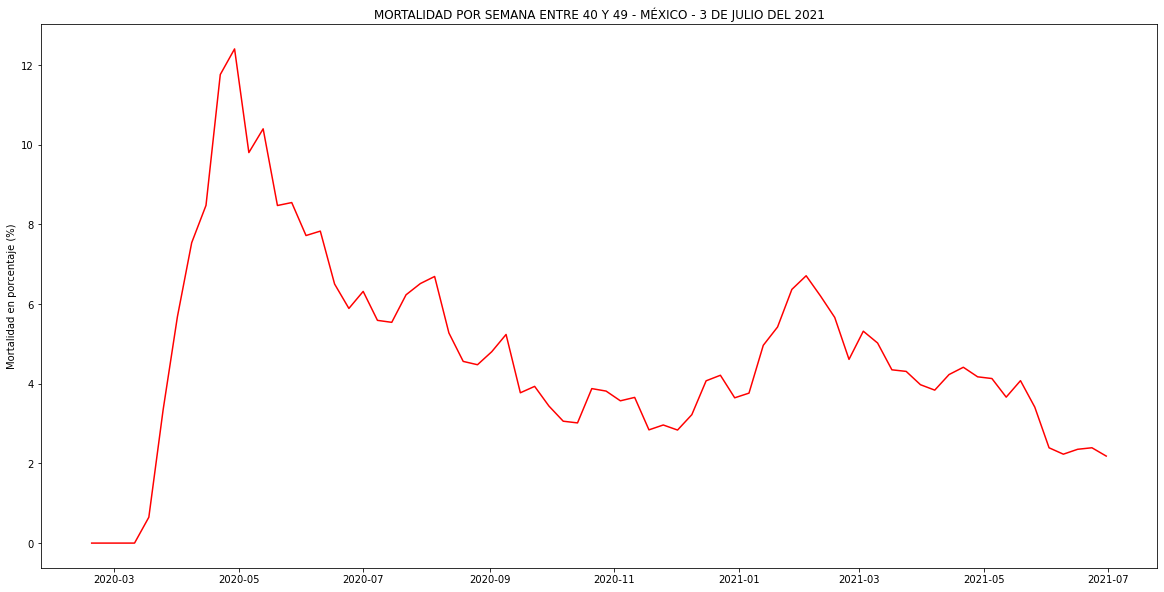

In [102]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 40 Y 49 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [103]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

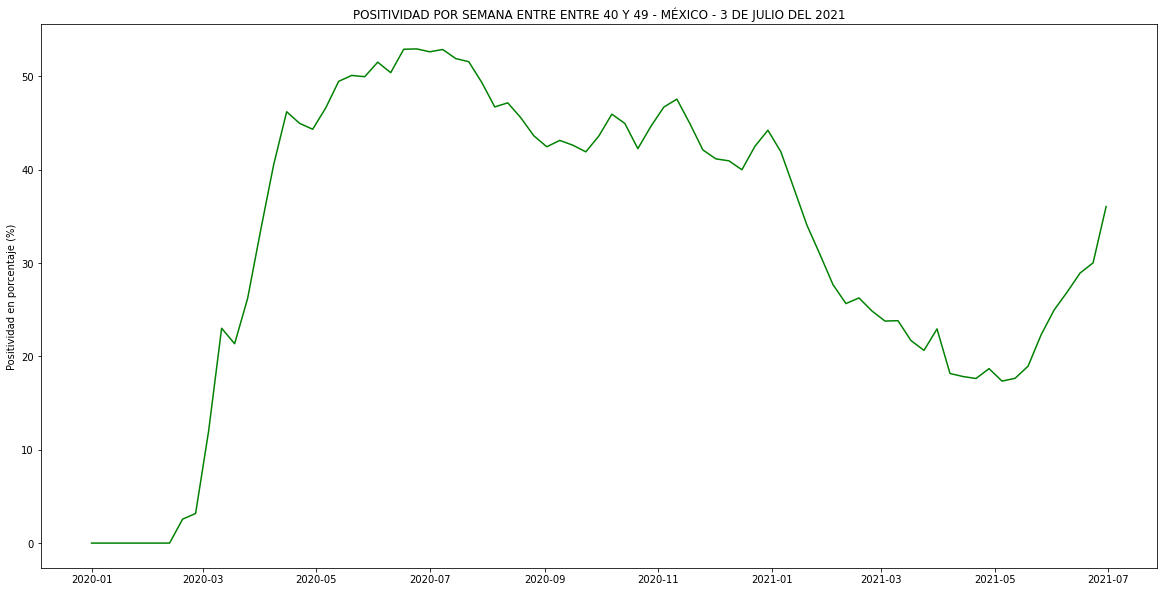

In [104]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE ENTRE 40 Y 49 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 30 y 39 años

In [105]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["30-39"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

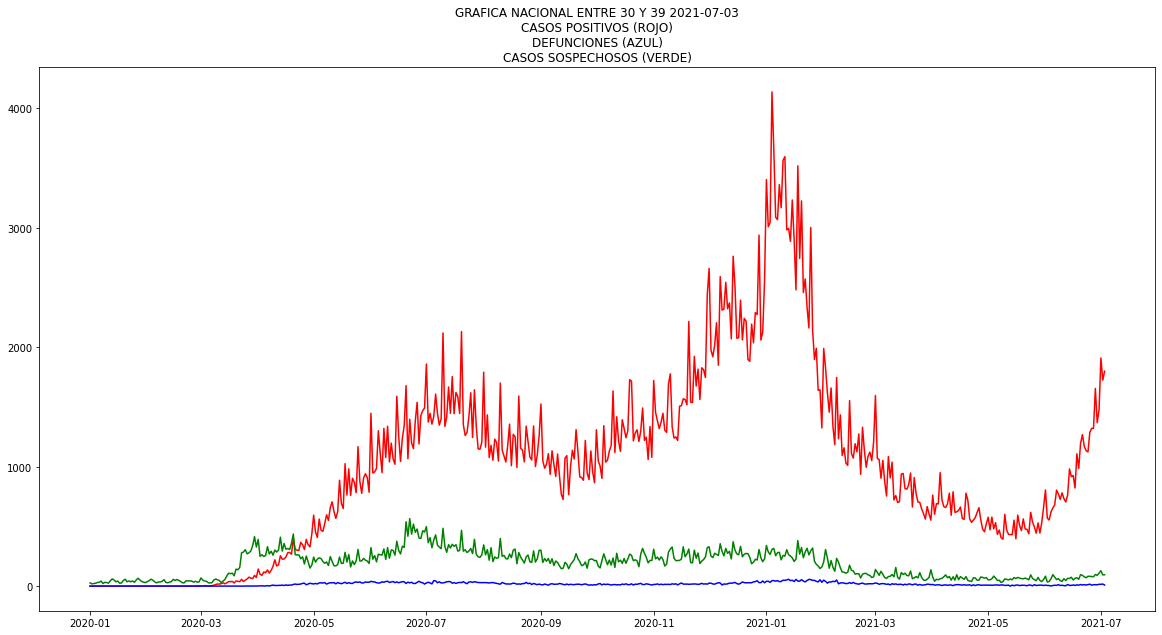

In [106]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 30 Y 39 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [107]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [108]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [109]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [110]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

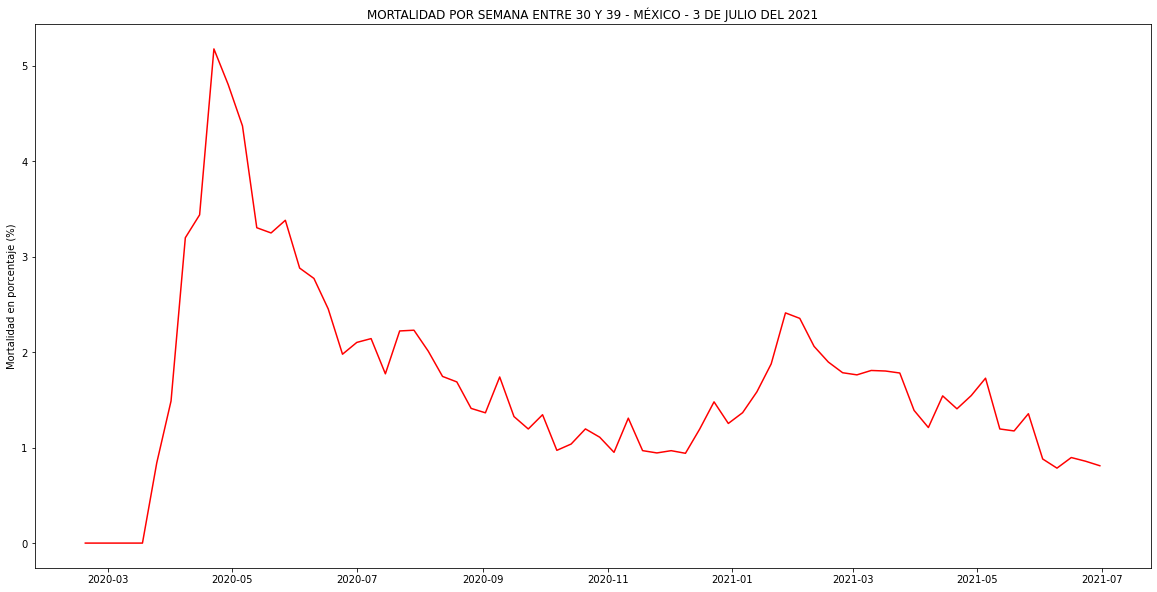

In [111]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [112]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

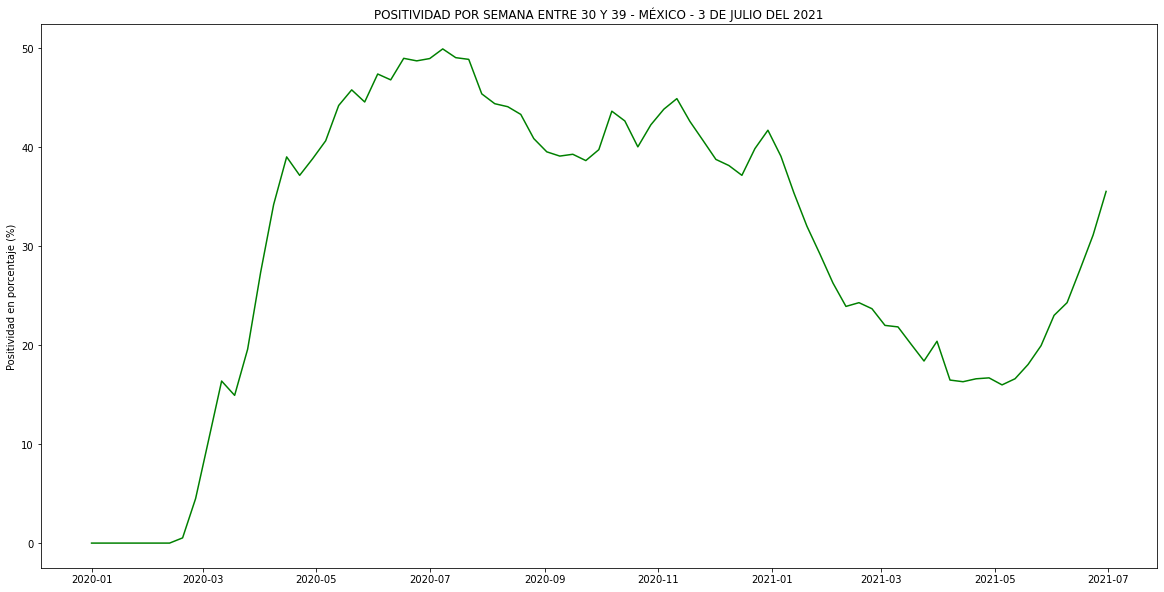

In [113]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 20 y 29 años

In [114]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["20-29"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

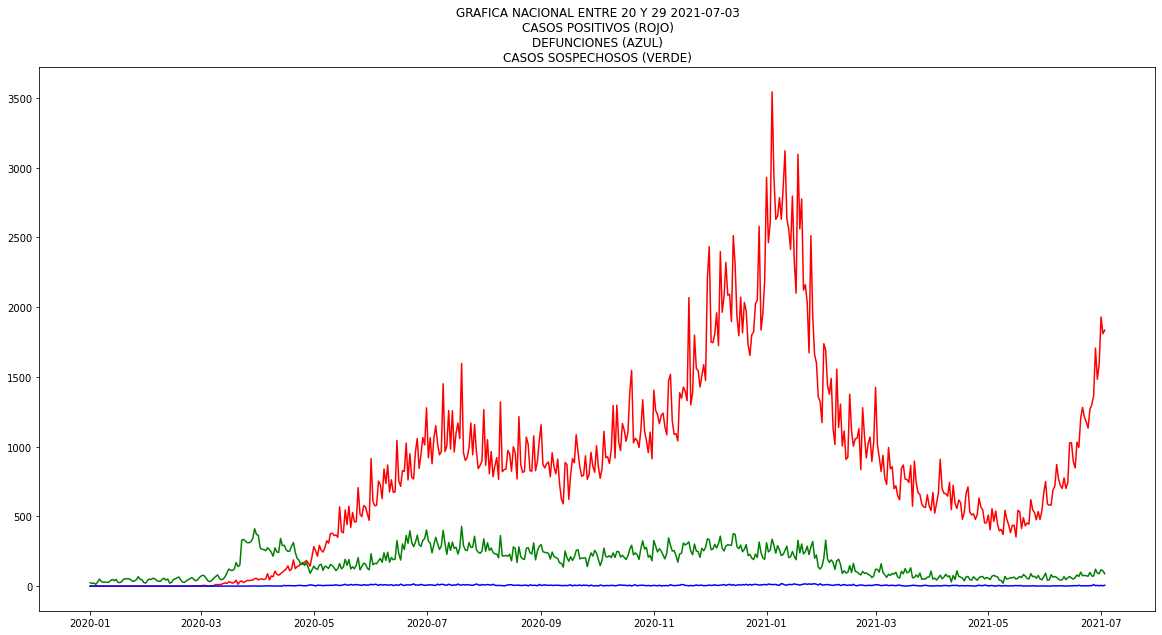

In [115]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 20 Y 29 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [116]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [117]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [118]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [119]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

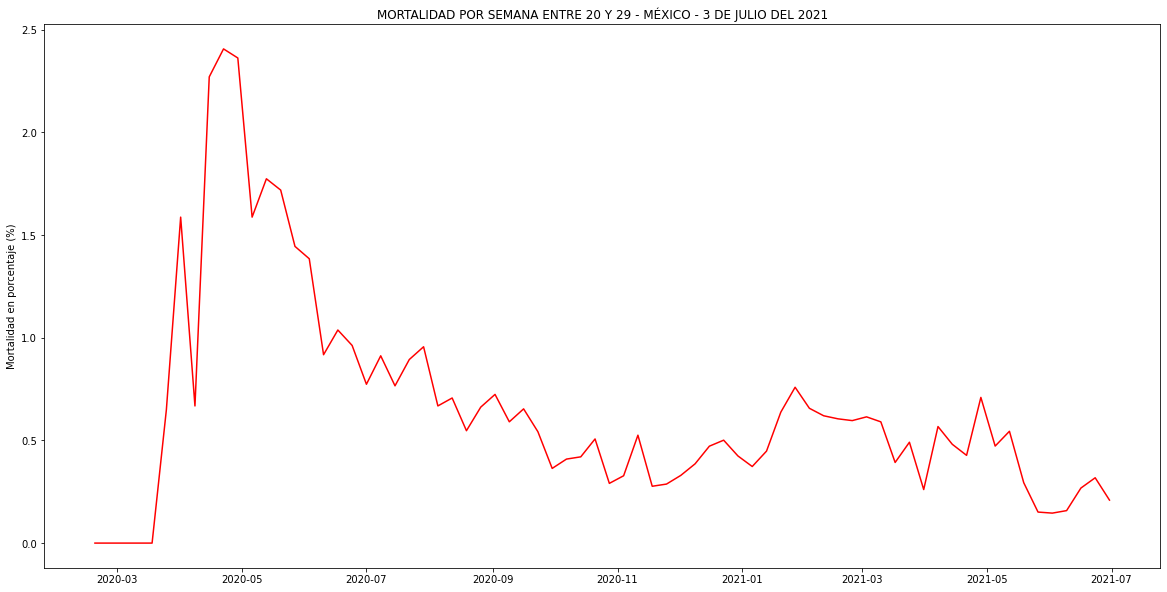

In [120]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [121]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

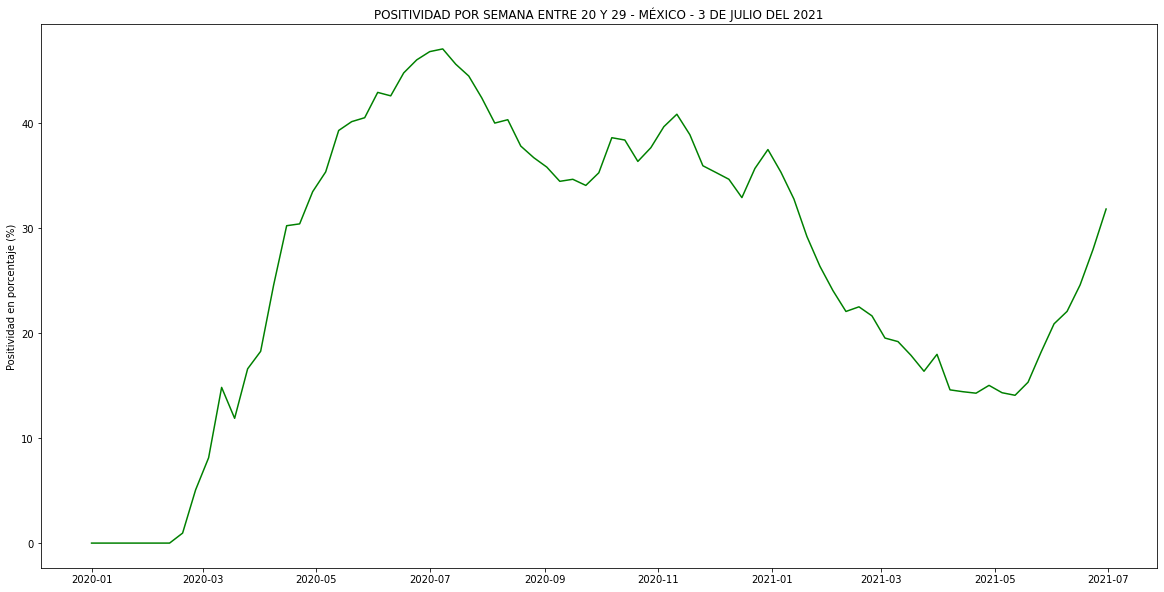

In [122]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Menores de 20 años

In [123]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["<20"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

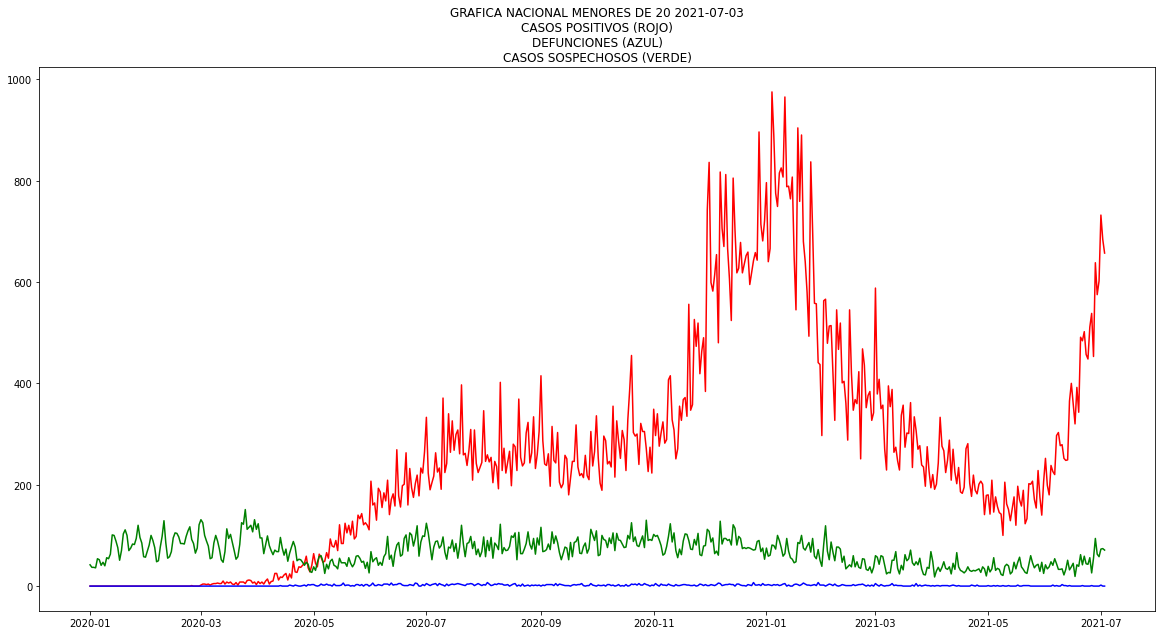

In [124]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MENORES DE 20 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [125]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [126]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [127]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [128]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

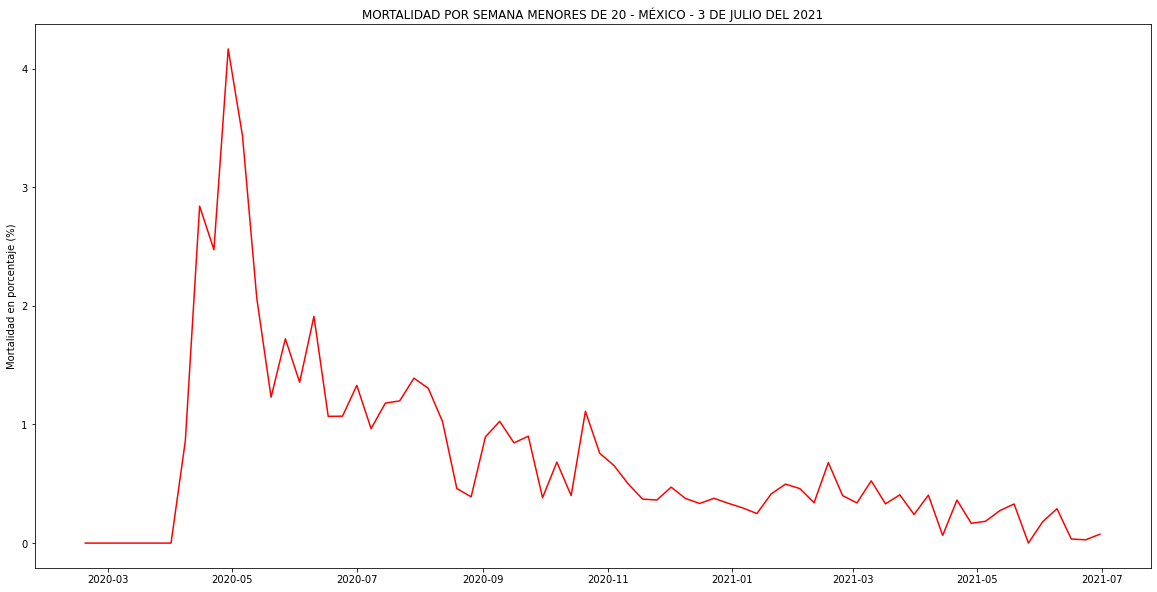

In [129]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MENORES DE 20 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [130]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

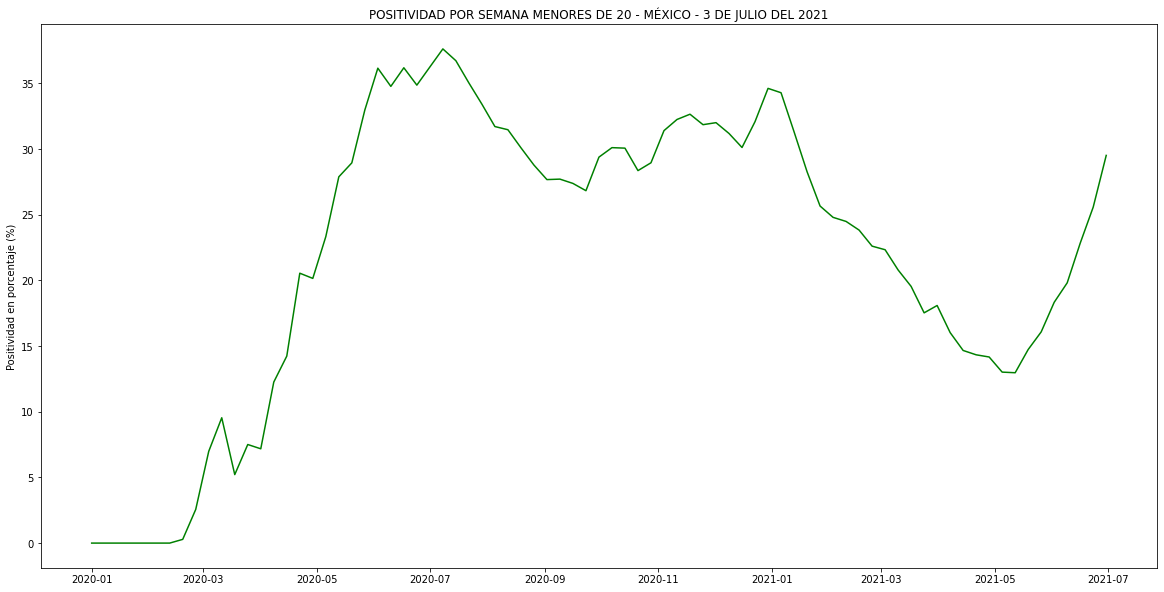

In [131]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MENORES DE 20 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

## Mortalidad en condiciones específicas
Se obtendrá la mortalidad y la incidancia de hospitalización y probabilidad de obtener enfermedad grave para algunos casos específicos.

###Caso Específico 1:

* SEXO_: HOMBRE
* EDAD: 21
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [132]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1])

In [133]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 21)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 14800
Porcentaje de Hospitalizados: 1.919%
Porcentaje de enfermos graves: 1.986%
Mortalidad: 0.236%


###Caso Específico 2:

* SEXO_: HOMBRE
* EDAD: 33
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [134]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1])

In [135]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 33)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 21876
Porcentaje de Hospitalizados: 5.805%
Porcentaje de enfermos graves: 5.019%
Mortalidad: 1.047%


###Caso Específico 3:

* SEXO_: HOMBRE
* EDAD: 35
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [136]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1])

In [137]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 35)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 21452
Porcentaje de Hospitalizados: 6.787%
Porcentaje de enfermos graves: 5.72%
Mortalidad: 1.338%


###Caso Específico 4:

* SEXO_: MUJER
* EDAD: 34
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [138]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1])

In [139]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "MUJER")
                           & (data_filtered["EDAD"] == 34)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 22852
Porcentaje de Hospitalizados: 3.785%
Porcentaje de enfermos graves: 3.413%
Mortalidad: 0.538%
